## Imports and dataset

In [1]:
from src.models.conjugate_bayes_lin_reg import NormalKnownVariancePriorLinearRegression
from src.utils import get_toy_data_indep
from src.utils import _torch_plot_ppds as plot_ppds
from src.attacks.distr_attacks import fgsm_attack, mlmc_attack, mlmc_gradient_estimator, kl_div, kl_to_appd

import numpy as np
import torch
from torch.optim import SGD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from joblib import Parallel, delayed

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
X, y = get_toy_data_indep(100)

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.9, random_state=42)

In [5]:
X_gray = X_test[-10:, :]
y_gray = y_test[-10:]

In [6]:
# Model for which we know the true gradient
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [7]:
# Fit the model
model_adv = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': 2 * torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data_adv = {'X': torch.tensor(X_gray, dtype=torch.float32), 'y': torch.tensor(y_gray, dtype=torch.float32)}
model_adv.fit(data_adv)

## APPD = N(mu, 2*sigma)

### Check gradient

In [8]:
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 10000).std()
appd = torch.distributions.normal.Normal(x.T @ model.mu, np.sqrt(2) * std)
x_adv = x.clone().detach().requires_grad_(True)  
optimizer = SGD([x_adv], lr=0.0)
x_adv.requires_grad = True
optimizer.zero_grad()

kl = kl_to_appd(model.mu, model.lam, model.sigma2, x_adv, x.T @ model.mu, 2 * std ** 2)
kl.backward()
real_grad = x_adv.grad.clone().detach()

In [ ]:
grads = []
for it in range(10000): 
    grads.append(-mlmc_gradient_estimator(appd.sample(), x_adv, 10, model))

# Plot 2 histograms, one for each feature
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
    axs[i].hist([grad[i].item() for grad in grads], bins=20)
    axs[i].axvline(real_grad[i].item(), color='red')
    axs[i].set_xlabel(f'Gradient {i}')
    axs[i].set_ylabel('Counts')

In [ ]:
# Attack example
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 10000).std()
appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, R=10, lr=.1, n_iter=400)
plot_ppds(model, x, x_adv_distr, appd)

In [ ]:
print(f'Punto inicial: {x} con varianza {std**2}.\n Punto final: {x_adv_distr} con varianza {model.sample_predictive_distribution(x_adv_distr, 10000).var()}')

In [ ]:
# Vector field of perturbations
torch.manual_seed(42)
np.random.seed(42)
def compute_perturbation(i):
    x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
    std = model.sample_predictive_distribution(x, 10000).std()
    appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * std)
    x_adv, x_adv_values = mlmc_attack(model, x, appd, R=10, lr=0.01, n_iter=400)
    return x_adv.clone().detach().numpy() - x.clone().detach().numpy()

perturbations = Parallel(n_jobs=-1)(delayed(compute_perturbation)(i) for i in range(X_test.shape[0]))

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)
# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=50, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0])-.1,max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1])-.1,max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.2)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

In [ ]:
plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)
plt.scatter(X_train[:,0], X_train[:,1], marker='x', label='Train points')
# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=50, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0])-.1,max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1])-.1,max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.2)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

<>:39: SyntaxWarning: invalid escape sequence '\e'
<>:39: SyntaxWarning: invalid escape sequence '\e'
/var/folders/xf/gv8n8flx2xv_bvk7b5qpnnsm0000gn/T/ipykernel_30468/4027516175.py:39: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


Early stopping at iteration 12
Early stopping at iteration 12
Early stopping at iteration 58
Early stopping at iteration 14
Early stopping at iteration 152
Early stopping at iteration 17
Early stopping at iteration 274
Early stopping at iteration 29
Early stopping at iteration 373
Early stopping at iteration 356
Early stopping at iteration 385
Early stopping at iteration 38
Early stopping at iteration 51
Early stopping at iteration 103
Early stopping at iteration 489
Early stopping at iteration 529
Early stopping at iteration 99
Early stopping at iteration 101
Early stopping at iteration 625
Early stopping at iteration 721
Early stopping at iteration 733
Early stopping at iteration 147
Early stopping at iteration 877
Early stopping at iteration 804
Early stopping at iteration 260
Early stopping at iteration 854
Early stopping at iteration 266
Early stopping at iteration 825
Early stopping at iteration 235
Early stopping at iteration 448
Early stopping at iteration 368
Early stopping at

Text(0, 0.5, 'KL Divergence')

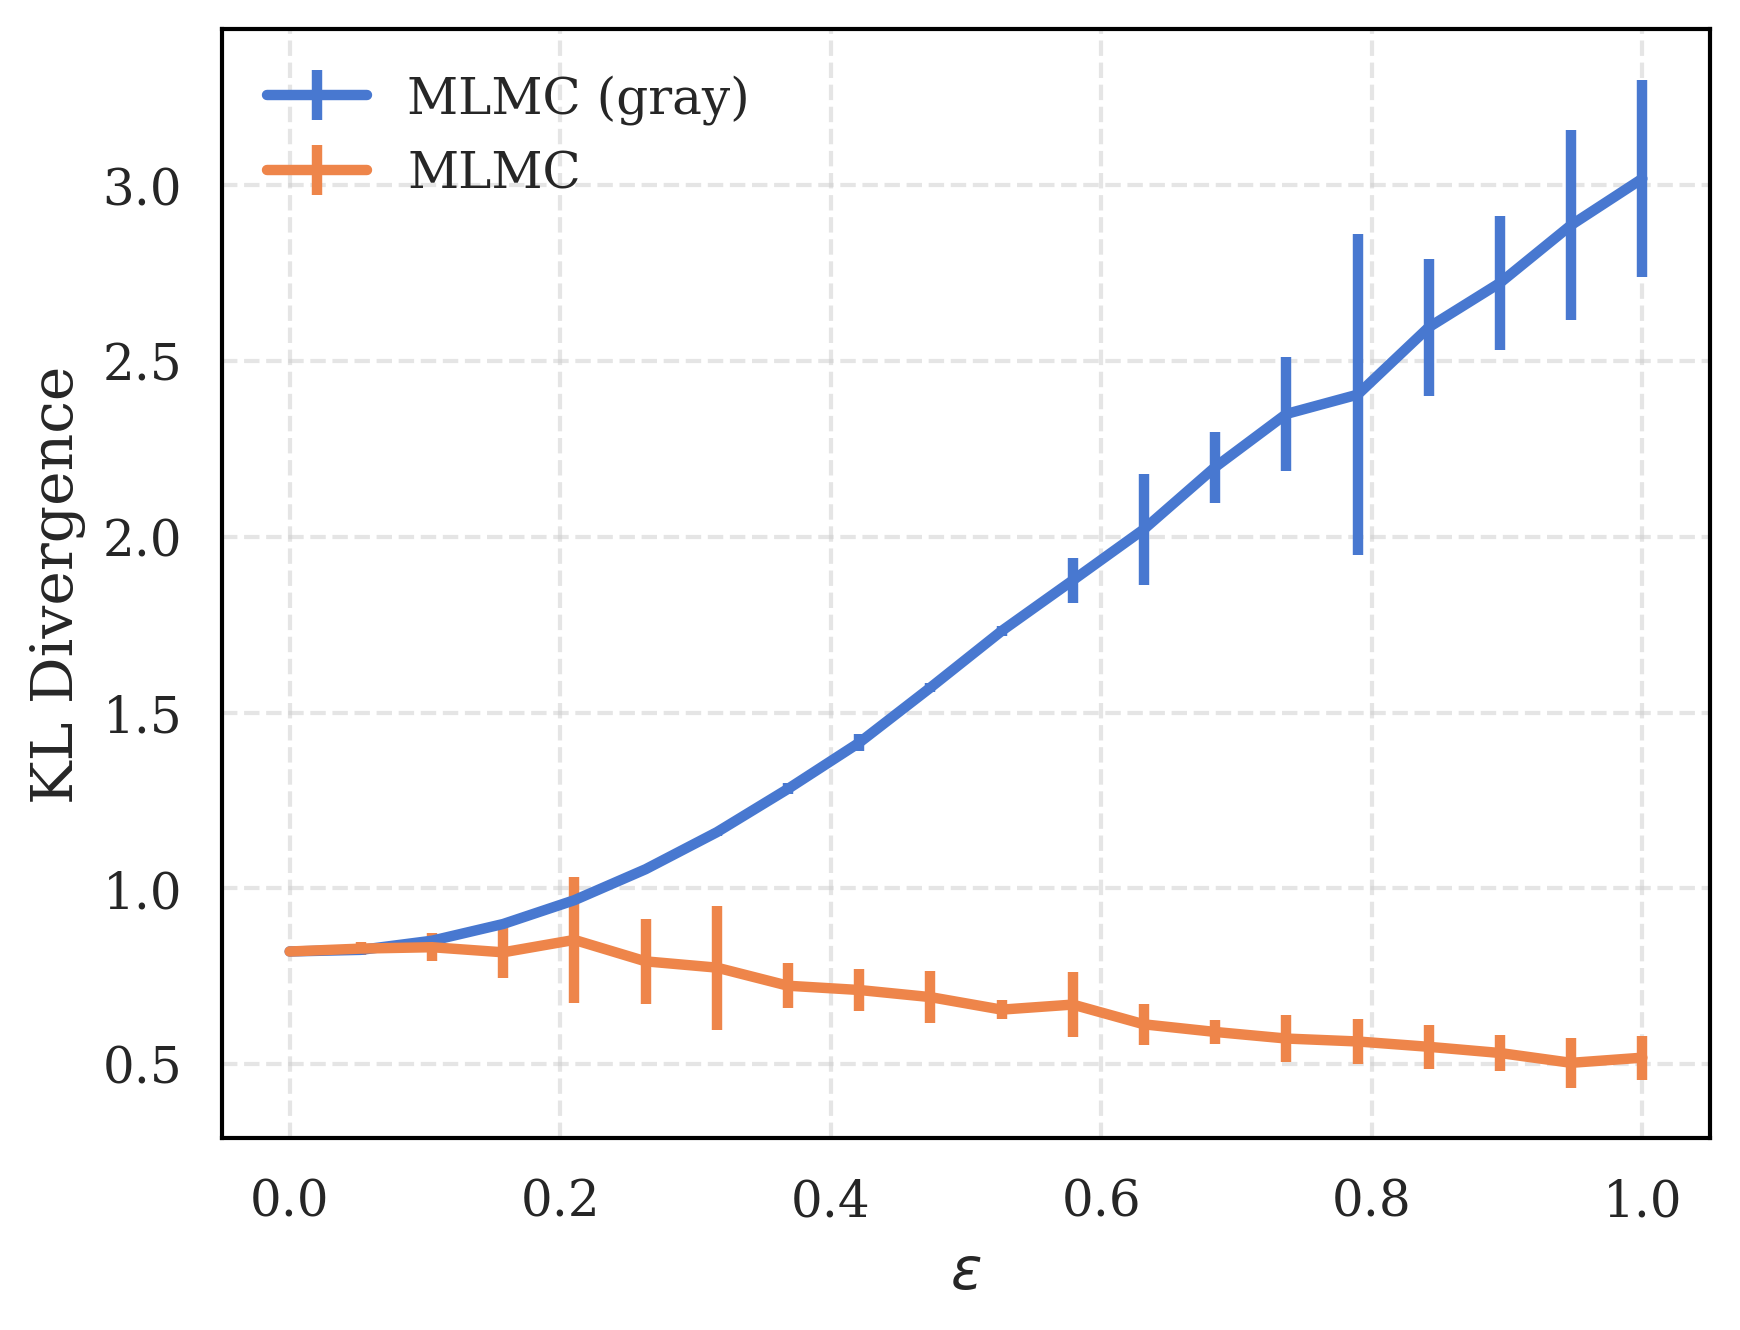

In [8]:
# plot KL divergence as a function of the strength of the attack  
n_jobs = -1
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 10000).std()
appd = torch.distributions.normal.Normal(x.T @ model.mu, 2 * std)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, appd, epsilon=epsilon, R=10, lr=0.01, n_iter=1000)
    kl = kl_to_appd(model.mu, model.lam, model.sigma2, x_adv_distr, x.T @ model.mu, 4 * std ** 2).item()
    x_fsgm = fgsm_attack(model, x, appd, epsilon=epsilon, R=10)
    kl_fsgm = kl_to_appd(model.mu, model.lam, model.sigma2, x_fsgm, x.T @ model.mu, 4 * std ** 2).item()
    x_gray, _ = mlmc_attack(model_adv, x, appd, epsilon=epsilon, R=10, lr=0.01, n_iter=1000)
    kl_gray = kl_to_appd(model.mu, model.lam, model.sigma2, x_gray, x.T @ model.mu, 4 * std ** 2).item()
    return kl, kl_fsgm, kl_gray


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
kl_gray = np.array(kl_alls)[:, :, 2]
# error bars as std
#plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.errorbar(epsilons, np.mean(kl_gray, axis=0, where=~np.isnan(kl_gray)), yerr=2*np.std(kl_gray, axis=0, where=~np.isnan(kl_gray)), label='MLMC (gray)')
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), yerr=2*np.std(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), label='MLMC')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')

<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
/var/folders/xf/gv8n8flx2xv_bvk7b5qpnnsm0000gn/T/ipykernel_30468/3111683802.py:7: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


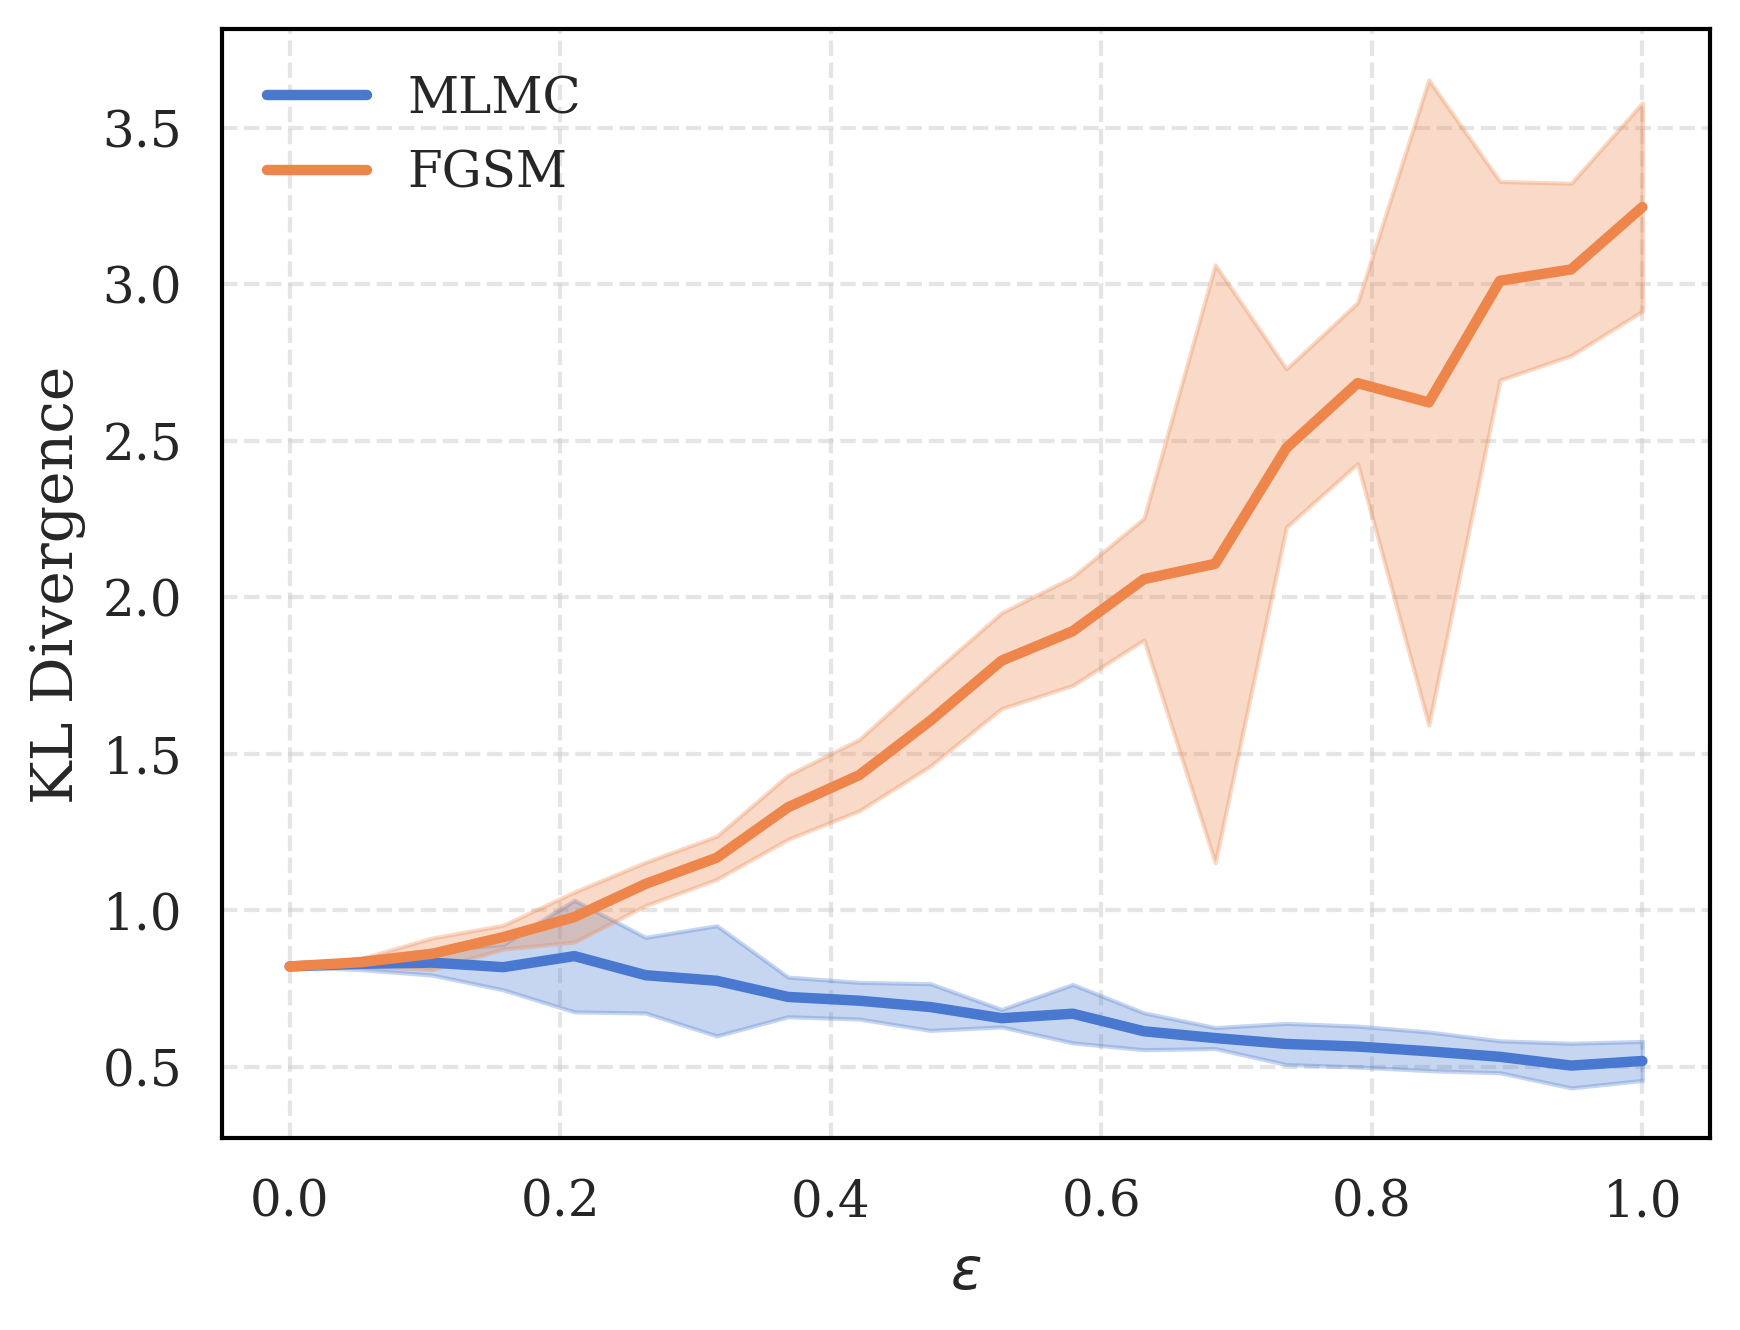

In [9]:
plt.plot(epsilons, np.mean(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), color='C0', label='MLMC')
plt.fill_between(epsilons, np.mean(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)) - 2*np.std(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)),
                    np.mean(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)) + 2*np.std(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), color='C0', alpha=0.3)
plt.plot(epsilons, np.mean(kl_fsgm, axis=0, where=~np.isnan(kl_fsgm)), color='C1', label='FGSM')
plt.fill_between(epsilons, np.mean(kl_fsgm, axis=0, where=~np.isnan(kl_fsgm)) - 2*np.std(kl_fsgm, axis=0, where=~np.isnan(kl_fsgm)),
                    np.mean(kl_fsgm, axis=0, where=~np.isnan(kl_fsgm)) + 2*np.std(kl_fsgm, axis=0, where=~np.isnan(kl_fsgm)), color='C1', alpha=0.3)
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')
plt.legend()

## APPD = N(2+mu, 2*sigma)

In [ ]:
# Attack example
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 10000).std()
appd = torch.distributions.normal.Normal(2 + x.T @ model.mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, R=10, lr=0.1, n_iter=400)
plot_ppds(model, x, x_adv_distr, appd)

In [ ]:
# Vector field of perturbations
def compute_perturbation(i):
    x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
    std = model.sample_predictive_distribution(x, 10000).std()
    appd = torch.distributions.normal.Normal(2 + x.T @ model.mu, 2 * std)
    x_adv, x_adv_values = mlmc_attack(model, x, appd, R=10, lr=0.01, n_iter=400)
    return x_adv.clone().detach().numpy() - x.clone().detach().numpy()

perturbations = Parallel(n_jobs=-1)(delayed(compute_perturbation)(i) for i in range(X_test.shape[0]))

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)

# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=20, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) - min(np.array(perturbations)[:,0])-.2,max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1])-.3,max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.1)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

In [ ]:
# plot KL divergence as a function of the strength of the attack 
n_jobs = -1
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
std = model.sample_predictive_distribution(x, 10000).std()
appd = torch.distributions.normal.Normal(2 + x.T @ model.mu, 2 * std)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, appd, epsilon=epsilon, R=10, lr=0.01, n_iter=1000)
    kl = kl_to_appd(model.mu, model.lam, model.sigma2, x_adv_distr, 2 + x.T @ model.mu, 4 * std ** 2).item()
    x_fsgm = fgsm_attack(model, x, appd, epsilon=epsilon, R=10)
    kl_fsgm = kl_to_appd(model.mu, model.lam, model.sigma2, x_fsgm, 2 + x.T @ model.mu, 4 * std ** 2).item()
    x_gray, _ = mlmc_attack(model_adv, x, appd, epsilon=epsilon, R=10, lr=0.01, n_iter=1000)
    kl_gray = kl_to_appd(model.mu, model.lam, model.sigma2, x_gray, 2 + x.T @ model.mu, 4 * std ** 2).item()
    return kl, kl_fsgm, kl_gray


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    #kl_values = [compute_kl_divergence(epsilon) for epsilon in epsilons]
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
kl_gray = np.array(kl_alls)[:, :, 2]
# error bars as std
#plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), yerr=2*np.std(kl_mlmc, axis=0, where=~np.isnan(kl_mlmc)), label='MLMC')
plt.errorbar(epsilons, np.mean(kl_gray, axis=0, where=~np.isnan(kl_gray)), yerr=2*np.std(kl_gray, axis=0, where=~np.isnan(kl_gray)), label='MLMC (gray)')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')

## Maximum disruption problem

In [22]:
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
lr = 0.0
mu_n = model.mu
lam_n = model.lam
sigma2 = model.sigma2
x_adv = x.clone().detach().requires_grad_(True)  
optimizer = SGD([x_adv], lr=0.0)
x_adv.requires_grad = True
optimizer.zero_grad()

kl = - kl_div(mu_n, lam_n, sigma2, x, x_adv)  # maximum disruption problem
kl.backward()
real_grad = x_adv.grad.clone().detach()

In [ ]:
grads = []
for it in range(1000):  # TODO: change to 10000
    y = model.sample_predictive_distribution(x, num_samples=1)
    grads.append(mlmc_gradient_estimator(y, x_adv, 10, model))

# Plot 2 histograms, one for each feature
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i in range(2):
    axs[i].hist([grad[i].item() for grad in grads], bins=20)
    axs[i].axvline(real_grad[i].item(), color='red')
    axs[i].set_xlabel(f'Gradient {i}')
    axs[i].set_ylabel('Counts')

In [ ]:
# Attack example
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
x_adv_distr, x_adv_values = mlmc_attack(model, x, epsilon=.5, R=10, lr=0.01, n_iter=400)
plot_ppds(model, x, x_adv_distr)

In [ ]:
# Vector field of perturbations
perturbations = []

for i in range(X_test.shape[0]):
    x = torch.tensor(X_test[i,:].copy(), dtype=torch.float32).unsqueeze(1)
    x_adv, x_adv_values = mlmc_attack(model, x, R=10, lr=0.01)
    perturbations.append(x_adv.clone().detach().numpy() - x.clone().detach().numpy())

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)

# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=40, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0]),max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1]),max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.1)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

In [ ]:
# plot KL divergence as a function of the strength of the attack 
n_jobs = 66
x = X_test[1,:].copy()
x = torch.tensor(x, dtype=torch.float32).unsqueeze(1)

# Function to calculate KL divergence for a given epsilon
def compute_kl_divergence(epsilon):
    x_adv_distr, _ = mlmc_attack(model, x, epsilon=epsilon, R=10)
    kl = kl_div(model.mu, model.lam, model.sigma2, x, x_adv_distr).item()
    x_fsgm = fgsm_attack(model, x, epsilon=epsilon, R=10)
    kl_fsgm = kl_div(model.mu, model.lam, model.sigma2, x, x_fsgm).item()
    return kl, kl_fsgm


# Define the range of epsilon values
epsilons = np.linspace(0, 1, 20)
kl_alls = []

for _ in range(10):
    # Use joblib to parallelize the computation of KL divergences
    kl_values = Parallel(n_jobs=n_jobs)(
        delayed(compute_kl_divergence)(epsilon) for epsilon in epsilons  
    )
    kl_alls.append(kl_values)

kl_mlmc = np.array(kl_alls)[:, :, 0]
kl_fsgm = np.array(kl_alls)[:, :, 1]
# error bars as std
plt.errorbar(epsilons, np.mean(kl_fsgm, axis=0), yerr=2*np.std(kl_fsgm, axis=0), label='FGSM')
plt.errorbar(epsilons, np.mean(kl_mlmc, axis=0), yerr=2*np.std(kl_mlmc, axis=0), label='MLMC')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('KL Divergence')